# Description

To write pure code for creating the model of Dogs vs Cats

https://www.kaggle.com/c/dogs-vs-cats

# Review: easy steps to train a world-class image classifier

Original plans:

1. precompute=True
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting


Edited by me:
1. Step 1: init
1. Step 2: finding learning rate
    1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Step 3a: first training
    1. precompute=True
    1. Train last layer from precomputed activations for 1-2 epochs
1. Step 3b: analyzing results
1. Step 4a: data augmentation
    1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Step 4b: analyzing results
1. Step 5a: unfreeze all layers
    1. Unfreeze all layers
    1. Set earlier layers to 3x-10x lower learning rate than next higher layer
    1. Use `lr_find()` again
    1. Train full network with cycle_mult=2 until over-fitting
1. Step 5b: analyzing results
1. Step 6a: TTA
1. Step 6b: analyzing results
1. Step 7: save the model

# Step 1a: init

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

PATH = "data/dogscats/"
sz=224

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.backends.cudnn.enabled

True

# Step 1b: function for analyzing results

In [4]:
from sklearn.metrics import confusion_matrix


def show_cm():
    log_preds = learn.predict() # this gives prediction for validation set. Predictions are in log scale
    preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
    probs = np.exp(log_preds[:,1])        # pr(dog)
    y = data.val_y # This is the label for a val data

    cm = confusion_matrix(y, preds)
    plot_confusion_matrix(cm, data.classes)
    
    return cm

    
def print_rates(cm):
    print('Predicted dogs = {}'.format(cm[1, 1] + cm[0, 1]))
    print('Predicted cats = {}'.format(cm[0, 0] + cm[1, 0]))
    predicted_dogs = cm[1, 1] + cm[0, 1]
    predicted_cats = cm[0, 0] + cm[1, 0]

    print('Actual dogs = {}'.format(cm[0, 0] + cm[0, 1]))
    print('Actual cats = {}'.format(cm[1, 0] + cm[1, 1]))
    actual_dogs = cm[0, 0] + cm[0, 1]
    actual_cats = cm[1, 0] + cm[1, 1]
    total = actual_dogs + actual_cats

    print('True dogs = {}'.format(cm[1, 1]))
    print('True cats = {}'.format(cm[0, 0]))
    true_dogs = cm[1, 1]
    true_cats = cm[0, 0]

    print('False dogs = {}'.format(cm[0, 1]))
    print('False cats = {}'.format(cm[1, 0]))
    false_dogs = cm[0, 1]
    false_cats = cm[1, 0]

    print('\n*** Rates ***\n')
    accuracy = (true_dogs + true_cats) / total
    print('Accuracy = %s' % accuracy)

    misclassification_rate = (false_dogs + false_cats) / total
    print('Misclassification rate = %s' % misclassification_rate)

    true_dogs_rate = true_dogs / actual_dogs
    print('True dogs rate = %s' % true_dogs_rate)

    true_cats_rate = true_cats / actual_cats
    print('True cats rate = %s' % true_cats_rate)

# Step 2: finding learning rate

In [3]:
# ITSMY:

arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))

In [5]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [5]:
lrf=learn.lr_find()

 81%|████████  | 290/360 [00:05<00:01, 52.72it/s, loss=0.229]


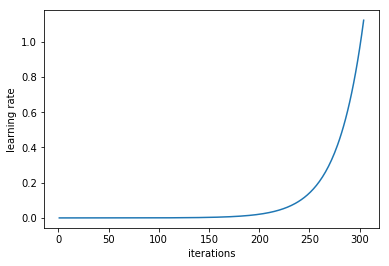

In [6]:
learn.sched.plot_lr()

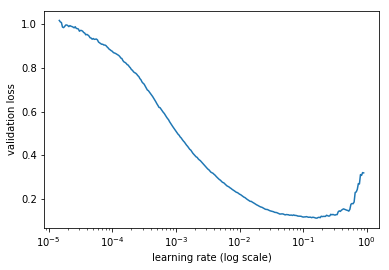

In [7]:
learn.sched.plot()

\# ITSMY:

We can see that the minimum of the valivation loss (~0.1) is equal to the 1e-1 of learning rate. As recommended in Lesson 2, we should choose a LR value one order of magnitude smaller. Hence, the LR must be 1e-2.

# Step 3a: first training

In [8]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.048453   0.029201   0.9855    
    1      0.052555   0.038781   0.9865                       



[array([0.03878]), 0.9865]

# Step 3b: save

In [14]:
learn.save('lesson1_a_v2_first_training')

In [15]:
learn.load('lesson1_a_v2_first_training')

# Step 3c: analyzing results

[[989  11]
 [ 13 987]]


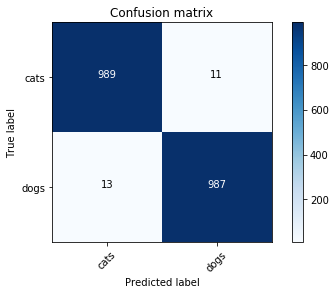

In [16]:
cm = show_cm()

In [17]:
print_rates(cm)

Predicted dogs = 998
Predicted cats = 1002
Actual dogs = 1000
Actual cats = 1000
True dogs = 987
True cats = 989
False dogs = 11
False cats = 13

*** Rates ***

Accuracy = 0.988
Misclassification rate = 0.012
True dogs rate = 0.987
True cats rate = 0.989


# Step 4a: data augmentation

In [5]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [6]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [7]:
arch = resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [8]:
learn.precompute=False

In [22]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.056604   0.031866   0.989     
    1      0.058076   0.025496   0.9895                       
    2      0.046125   0.027855   0.989                        



[array([0.02785]), 0.989]

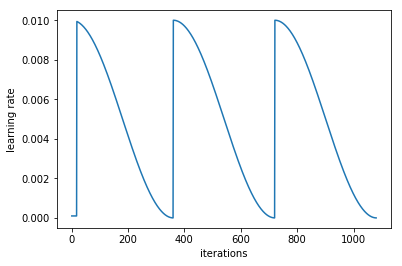

In [23]:
learn.sched.plot_lr()

# Step 4b: save

In [26]:
learn.save('lesson1_a_v2_data_augmentation')

In [9]:
learn.load('lesson1_a_v2_data_augmentation')

# Step 4b: analyzing results

[[994   6]
 [ 16 984]]


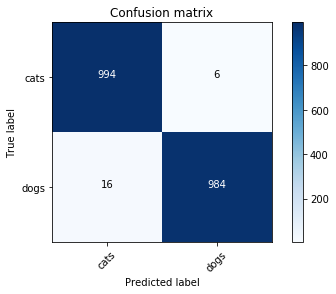

In [10]:
cm = show_cm()

In [11]:
print_rates(cm)

Predicted dogs = 990
Predicted cats = 1010
Actual dogs = 1000
Actual cats = 1000
True dogs = 984
True cats = 994
False dogs = 6
False cats = 16

*** Rates ***

Accuracy = 0.989
Misclassification rate = 0.011
True dogs rate = 0.984
True cats rate = 0.994


# Step 5a: unfrezze all layers

In [12]:
learn.unfreeze()

In [13]:
lr=np.array([1e-4,1e-3,1e-2])

In [14]:
learn.fit(lr, 4, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.061163   0.024625   0.99      
    1      0.041651   0.019355   0.9935                       
    2      0.03439    0.020177   0.993                        
    3      0.027957   0.019671   0.9915                       
    4      0.025359   0.020301   0.992                        
    5      0.023988   0.017067   0.9935                       
    6      0.017537   0.017397   0.993                        
    7      0.019112   0.017589   0.994                        
    8      0.025725   0.017187   0.9935                       
    9      0.015503   0.019291   0.9915                       
    10     0.014159   0.017891   0.994                         
    11     0.011338   0.018998   0.9925                        
 17%|█▋        | 61/360 [00:33<02:44,  1.81it/s, loss=0.0112]

KeyboardInterrupt: 

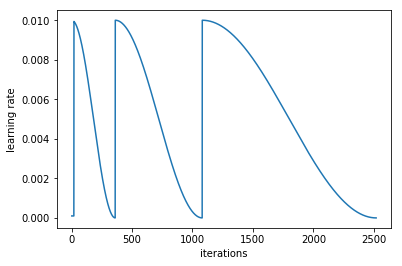

In [37]:
learn.sched.plot_lr()

# Step 5b: save

In [38]:
learn.save('lesson1_a_v2_unfreeze_all_layers')

In [39]:
learn.load('lesson1_a_v2_unfreeze_all_layers')

# Step 5c: analyzing results

[[990  10]
 [  6 994]]


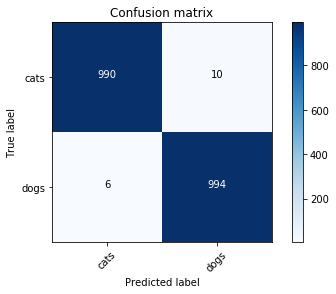

In [40]:
cm = show_cm()

In [41]:
print_rates(cm)

Predicted dogs = 1004
Predicted cats = 996
Actual dogs = 1000
Actual cats = 1000
True dogs = 994
True cats = 990
False dogs = 10
False cats = 6

*** Rates ***

Accuracy = 0.992
Misclassification rate = 0.008
True dogs rate = 0.994
True cats rate = 0.99


# Step 6a: TTA

In [42]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

# Step 6b: save

In [43]:
learn.save('lesson1_a_v2_tta')

In [44]:
learn.load('lesson1_a_v2_tta')

# Step 6b: analyzing results

[[990  10]
 [  6 994]]


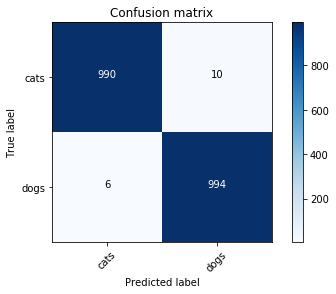

In [45]:
cm = show_cm()

In [46]:
print_rates(cm)

Predicted dogs = 1004
Predicted cats = 996
Actual dogs = 1000
Actual cats = 1000
True dogs = 994
True cats = 990
False dogs = 10
False cats = 6

*** Rates ***

Accuracy = 0.992
Misclassification rate = 0.008
True dogs rate = 0.994
True cats rate = 0.99
